### Imports

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%config InlineBackend.figure_format = 'retina'  # resolution setting for plots

In [3]:
%matplotlib inline
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Dataset
_**Heart Disease Cleveland UCI**_ – [kaggle.com](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci)

In [4]:
heart_dis_data = pd.read_csv("heart_cleveland_upload.csv")

In [5]:
ANSWERS = "condition"  # `0` = no disease, `1` = disease

### Features

In [6]:
discrete_features = ["sex",       # 2. `1` = male; `0` = female
                     "cp",        # 3. chest pain type (`0` = typical angina; `1` = atypical angina; `2` = non-anginal pain; `3` = asymptomatic)
                     "fbs",       # 6. (fasting blood sugar > 120 mg/dl) (`1` = true; `0` = false)
                     "restecg",   # 7. resting electrocardiographic results (`0` = normal; `1` = having ST-T wave abnormality; `2` = showing probable or definite left ventricular hypertrophy by Estes' criteria)
                     "exang",     # 9. exercise induced angina (`1` = yes; `0` = no)
                     "slope",     # 11. the slope of the peak exercise ST segment (`0` = upsloping; `1` = flat; `2` = downsloping)
                     "ca",        # 12. number of major vessels (`0-3`) colored by flourosopy
                     "thal"       # 13. `0` = normal; `1` = fixed defect; `2` = reversable defect
                    ]

In [7]:
continuous_features = ["age",       # 1. age
                       "trestbps",  # 4. resting blood pressure in mmHg
                       "chol",      # 5. serum cholestoral in mg/dl
                       "thalach",   # 8. maximum heart rate achieved
                       "oldpeak"    # 10. ST depression induced by exercise relative to rest
                      ]

In [8]:
data_only_features = heart_dis_data.drop(ANSWERS, axis=1)
data_only_features.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0


## Model

### Data normalization

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# convert categorical variable into indicator variables
norm_data_only_features = pd.get_dummies(data_only_features, columns=discrete_features)

scaler = StandardScaler()  # x := (x - mean(x)) / standart_deviation(x)
norm_data_only_features[continuous_features] = scaler.fit_transform(heart_dis_data[continuous_features])

norm_data_only_features.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,thal_0,thal_1,thal_2
0,1.600302,1.596266,-0.257179,-0.812095,-0.820813,0,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,1.600302,0.468418,-0.160859,0.061157,0.639470,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
2,1.268242,1.032342,-0.411292,-1.554358,1.326662,1,0,1,0,0,...,0,0,1,1,0,0,0,1,0,0
3,1.157555,0.355633,0.667499,1.065396,0.295874,0,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1.046868,-1.223355,-0.700254,-0.244481,0.639470,0,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0


### Imports

In [11]:
import os
import pickle
import optuna

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score

In [13]:
X_train, X_test, y_train, y_test = train_test_split(norm_data_only_features, 
                                                    heart_dis_data[ANSWERS], 
                                                    test_size=0.2, 
                                                    random_state=32)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [15]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING) # disable warnings


N_TRIALS = 300


def objective(trial):
    # choose classifier for the trial
    classifier = trial.suggest_categorical("classifier", ["RandomForest", "LogReg"])
    
    if classifier == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 2, 25)
        max_depth = trial.suggest_int("max_depth", 2, 40)
        # max_depth = int(trial.suggest_float("max_depth", 1, 40, log=True))

        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth)
    else:  # LogisticRegression classifier
        reg_strength = trial.suggest_float("logistic-regularization", 1e-4, 1)
        intercept_scaling = trial.suggest_float("lr_intercept_scaling", 1e-4, 1)
    
        clf = LogisticRegression(C=reg_strength, solver="liblinear", 
                                 intercept_scaling=intercept_scaling)
    #
    with open(os.path.join("models", f"{trial.number}.pkl"), "wb") as file:
        pickle.dump(clf, file)
    # return accuracy
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

print(f"Accuracy: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

Accuracy: 0.8736702127659575
Best hyperparameters: {'classifier': 'LogReg', 'logistic-regularization': 0.44850313382734613, 'lr_intercept_scaling': 0.37602116282384473}
CPU times: user 2.63 s, sys: 292 ms, total: 2.92 s
Wall time: 8.25 s


In [16]:
with open(os.path.join("models", f"{study.best_trial.number}.pkl"), "rb") as file:
    best_clf = pickle.load(file)

best_clf.fit(X_train, y_train)  # train the classifier extracted from file
y_pred = best_clf.predict(X_test)  # test

print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test f1-score: {f1_score(y_test, y_pred)}")

Test accuracy: 0.8166666666666667
Test f1-score: 0.7755102040816326


In [17]:
# considering all dataset to evaluate accuracy
cv_acc_mean = cross_val_score(best_clf, 
                              norm_data_only_features, heart_dis_data[ANSWERS],
                              scoring="roc_auc", cv=5).mean()
print(f"Accuracy: {cv_acc_mean}")

Accuracy: 0.8885416666666666


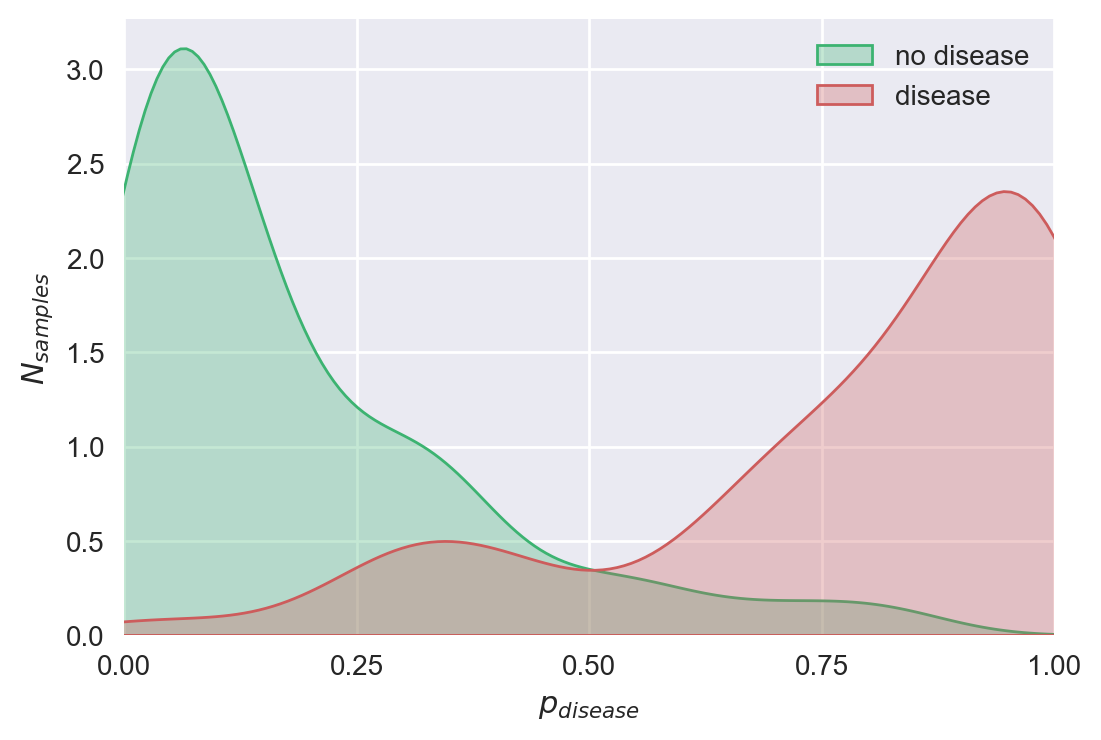

In [23]:
# plot settings
plt.figure(figsize=(6, 4))
no_disease_color_dark = "mediumseagreen"
disease_color_dark = "indianred"


def kde(y_pred_proba, target_val):
    sns.kdeplot(y_pred_proba[target_val==0], 
                label="no disease", color=no_disease_color_dark,
                linewidth=1, alpha=0.3, fill=True) 
    sns.kdeplot(y_pred_proba[target_val==1], 
                label="disease", color=disease_color_dark,
                linewidth=1, alpha=0.3, fill=True) 
    plt.xlabel("$p_{disease}$")
    plt.xticks(np.arange(0, 1.25, 0.25))
    plt.xlim([0, 1])
    plt.ylabel("$N_{samples}$")
    plt.legend()


kde(best_clf.predict_proba(X_train)[:, 1], y_train)
plt.show()